In [24]:
import requests
import json

def generate_question(chunk, model_name="llama3.2"):
    """
    Generate a single question-answer pair from a given text chunk using an Ollama model.
    
    Args:
        chunk (str): The text chunk to generate a QA pair from
        model_name (str): The name of the Ollama model to use (default: "llama3.2")
        
    Returns:
        str: Generated question-answer pair in tuple format
    """
    # Ollama API endpoint (default is localhost on port 11434)
    api_url = "http://localhost:11434/api/generate"
    
    # Create the prompt for question and answer generation
    prompt = f"""
    You are an expert question-answer pair generator. Your task is to create exactly ONE high-quality question and its corresponding answer based on the provided text chunk.

    TEXT CHUNK:
    {chunk}

    INSTRUCTIONS:
    1. Generate ONE question-answer pair that captures key information from the text chunk.
    2. The answer must be comprehensive, accurate, and fully supported by the text.
    3. The answer should be 1 sentence long - informative but concise.
    4. The question should belong to one of these categories:
       - Basic factual questions (e.g., "When was Carnegie Mellon University founded?")
       - Document-enhanced questions that benefit from specific textual context (e.g., "What is the name of the annual pickle festival held in Pittsburgh?")
       - Specific information questions that require exact details from the text (e.g., "When was the Pittsburgh Soul Food Festival established?")
       - Time-sensitive questions related to events, schedules, or dates (e.g., "Who is performing at City Theatre on May 15th?")
    5. Vary the question types across different chunks to ensure diversity.
    
    OUTPUT FORMAT:
    Return ONLY a Python tuple with proper formatting: ("Question text", "Answer text")
    - Include proper quotes and parentheses
    - No explanations, comments, or additional text
    - No numbering or prefixes
    
    Generate a question-answer pair now:
    """
    
    # Prepare the request payload
    payload = {
        "model": model_name,
        "prompt": prompt,
        "stream": False
    }
    
    try:
        # Make the API request to Ollama
        response = requests.post(api_url, json=payload)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        # Parse the response
        result = response.json()
        return result["response"].strip()
    
    except requests.exceptions.RequestException as e:
        print(f"Error communicating with Ollama: {e}")
        return None
    except (KeyError, json.JSONDecodeError) as e:
        print(f"Error processing Ollama response: {e}")
        return None

In [25]:
chunk = "The Los Angeles Dodgers won the World Series in 2020. The games were played in Arlington, Texas, at Globe Life Field due to the COVID-19 pandemic."

questions = generate_question(chunk, model_name="gemma3:12b")
print(questions)

("Where did the Los Angeles Dodgers play the World Series in 2020?", "The Los Angeles Dodgers played the World Series in 2020 in Arlington, Texas, at Globe Life Field due to the COVID-19 pandemic.")


In [14]:
import re
tuple_match = re.search(r'\(\".*?\", \".*?\"\)', questions)
tuple_str = tuple_match.group(0)
tuple_str
eval(tuple_str)

('What year did the Los Angeles Dodgers win the World Series?',
 'The Los Angeles Dodgers won the World Series in 2020.')

In [68]:
# questions.strip().split("\n")

In [21]:
## read csv file
import pandas as pd
from tqdm import tqdm
df = pd.read_csv("all_combined.csv", lineterminator='\n')
print(len(df["text"]))



12370


In [30]:
def generate_questions_for_dataset(df, model_name="llama3.3:latest", max_attempts=5, save_path="all_combined.csv"):
    """
    Generate questions for each text in the dataframe using the specified model.
    
    Args:
        df: DataFrame containing a 'text' column
        model_name: Name of the model to use for question generation
        max_attempts: Maximum number of attempts for each text
        save_path: Path to save the updated dataframe
        
    Returns:
        Updated DataFrame with a new column containing generated questions
    """

    
    # Create a list to store all questions
    all_questions = []
    all_answers = []
    # Create a file to log generation results
    log_file = open(f"{model_name}_question_generation_log.txt", "w")

    # Add tqdm progress bar
    for i in tqdm(range(len(df)), desc=f"Generating questions with {model_name}"):
        # if i % 100 == 0:
        #     print("current row index: ", i)
        attempts = 0
        question = None
        
        while attempts < max_attempts:
            try:
                response = generate_question(df["text"][i], model_name=model_name)
                # print("The text is: ", df["text"][i])
                if model_name == "deepseek-r1":
                    tuple_match = re.search(r'\(\".*?\", \".*?\"\)', response)
                    tuple_str = tuple_match.group(0)
                    question, answer = eval(tuple_str)
                else:
                    question, answer = eval(response)
                if question and answer:  # If we got a valid response
                    # print("-------- ---------")
                    # print(question)
                    # print(answer)
                    # print("-------- ---------")
                    break
                raise Exception("Empty response received")
                
            except Exception as e:
                attempts += 1
                print(f"Attempt {attempts} failed: {str(e)}")
                if attempts == max_attempts:
                    print(f"Failed to generate question after {max_attempts} attempts")
        
        # Add the question to our list (empty string if generation failed)
        if question and answer:
            all_questions.append(question)
            all_answers.append(answer)
            log_file.write(f"{i}\t{question}\t{answer}\n")
        else:
            all_questions.append("")
            all_answers.append("")
            log_file.write(f"{i}\t\n")
    # Close the log file
    log_file.close()

    # After collecting all questions, add them as a new column
    column_name = f"{model_name}_question"
    df[column_name] = all_questions
    column_name = f"{model_name}_answer"
    df[column_name] = all_answers

    # Save the final dataframe once at the end
    df.to_csv(save_path, index=False)
    
    return df

In [31]:
generate_questions_for_dataset(df, model_name="gemma3:12b", save_path="all_combined_gemma3.csv")

Generating questions with gemma3:12b:   0%|          | 57/12370 [00:50<2:41:35,  1.27it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:   0%|          | 58/12370 [00:52<3:34:46,  1.05s/it]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:   0%|          | 59/12370 [00:58<8:23:53,  2.46s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:   1%|          | 115/12370 [01:49<2:56:57,  1.15it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:   2%|▏         | 268/12370 [04:14<3:08:27,  1.07it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:   2%|▏         | 285/12370 [04:32<3:28:48,  1.04s/it]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:   2%|▏         | 286/12370 [04:36<6:32:49,  1.95s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:   3%|▎         | 349/12370 [05:31<2:36:45,  1.28it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:   3%|▎         | 382/12370 [06:00<2:33:02,  1.31it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:   3%|▎         | 383/12370 [06:03<5:36:45,  1.69s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:   4%|▍         | 474/12370 [07:17<2:36:45,  1.26it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:   4%|▍         | 479/12370 [07:28<4:30:48,  1.37s/it]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:   5%|▌         | 624/12370 [09:29<3:12:29,  1.02it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:   5%|▌         | 654/12370 [09:57<3:06:56,  1.04it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:   5%|▌         | 664/12370 [10:08<3:03:37,  1.06it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:   7%|▋         | 888/12370 [13:04<2:05:20,  1.53it/s] 

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:   9%|▉         | 1131/12370 [16:26<2:44:21,  1.14it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  11%|█         | 1345/12370 [19:14<2:30:18,  1.22it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  12%|█▏        | 1469/12370 [20:50<2:21:26,  1.28it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  12%|█▏        | 1488/12370 [21:08<2:20:30,  1.29it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  13%|█▎        | 1644/12370 [23:11<2:05:16,  1.43it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  13%|█▎        | 1656/12370 [23:29<2:25:06,  1.23it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  14%|█▎        | 1699/12370 [24:11<2:17:25,  1.29it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  18%|█▊        | 2166/12370 [29:34<2:26:58,  1.16it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  18%|█▊        | 2260/12370 [30:55<2:14:09,  1.26it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  19%|█▉        | 2335/12370 [32:01<2:23:31,  1.17it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  20%|█▉        | 2437/12370 [33:30<2:04:27,  1.33it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  20%|██        | 2516/12370 [34:39<2:13:52,  1.23it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  23%|██▎       | 2815/12370 [38:32<1:49:19,  1.46it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  25%|██▌       | 3148/12370 [42:56<2:01:14,  1.27it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  26%|██▌       | 3156/12370 [43:09<2:17:27,  1.12it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  26%|██▋       | 3252/12370 [44:30<1:39:15,  1.53it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  28%|██▊       | 3454/12370 [47:14<1:56:28,  1.28it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  29%|██▉       | 3623/12370 [49:34<1:44:52,  1.39it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  31%|███       | 3789/12370 [51:56<1:37:55,  1.46it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  31%|███       | 3790/12370 [51:59<3:20:02,  1.40s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  31%|███       | 3802/12370 [52:09<1:47:39,  1.33it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  31%|███       | 3822/12370 [52:28<2:12:42,  1.07it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  31%|███       | 3858/12370 [53:02<1:51:25,  1.27it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  31%|███       | 3863/12370 [53:07<2:07:22,  1.11it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  31%|███▏      | 3866/12370 [53:17<4:38:44,  1.97s/it]<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 1 failed: 'str' object is not callable


Generating questions with gemma3:12b:  34%|███▎      | 4161/12370 [56:46<1:36:34,  1.42it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  34%|███▎      | 4162/12370 [56:51<4:20:19,  1.90s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  36%|███▋      | 4490/12370 [1:00:36<1:32:53,  1.41it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  38%|███▊      | 4684/12370 [1:02:59<1:52:53,  1.13it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  38%|███▊      | 4685/12370 [1:03:05<5:01:06,  2.35s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  38%|███▊      | 4695/12370 [1:03:12<1:25:50,  1.49it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  46%|████▌     | 5715/12370 [1:16:01<1:24:36,  1.31it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  50%|█████     | 6210/12370 [1:22:05<1:10:12,  1.46it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  50%|█████     | 6211/12370 [1:22:08<2:43:38,  1.59s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  52%|█████▏    | 6473/12370 [1:25:17<1:11:55,  1.37it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 2 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 3 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 4 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  52%|█████▏    | 6474/12370 [1:25:22<2:59:59,  1.83s/it]

Attempt 5 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  52%|█████▏    | 6486/12370 [1:25:32<1:16:57,  1.27it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 2 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 3 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 4 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  52%|█████▏    | 6487/12370 [1:25:36<2:49:30,  1.73s/it]

Attempt 5 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  54%|█████▎    | 6621/12370 [1:27:40<1:13:53,  1.30it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 2 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 3 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 4 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  54%|█████▎    | 6622/12370 [1:27:44<2:48:09,  1.76s/it]

Attempt 5 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  54%|█████▎    | 6634/12370 [1:27:53<1:15:38,  1.26it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 2 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 3 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 4 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  54%|█████▎    | 6635/12370 [1:27:58<3:10:23,  1.99s/it]

Attempt 5 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  54%|█████▍    | 6660/12370 [1:28:18<1:18:45,  1.21it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  54%|█████▍    | 6692/12370 [1:28:46<1:10:48,  1.34it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  54%|█████▍    | 6719/12370 [1:29:08<1:14:07,  1.27it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  56%|█████▋    | 6964/12370 [1:32:38<1:10:58,  1.27it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  57%|█████▋    | 6997/12370 [1:33:14<1:20:48,  1.11it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 2 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 3 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 4 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  57%|█████▋    | 6998/12370 [1:33:18<2:43:58,  1.83s/it]

Attempt 5 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  57%|█████▋    | 7020/12370 [1:33:37<1:17:15,  1.15it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  59%|█████▉    | 7289/12370 [1:37:41<1:15:07,  1.13it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  64%|██████▎   | 7861/12370 [1:44:43<57:47,  1.30it/s]  

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  64%|██████▎   | 7862/12370 [1:44:50<3:14:18,  2.59s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  69%|██████▊   | 8498/12370 [1:52:25<44:51,  1.44it/s]  

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  69%|██████▉   | 8573/12370 [1:53:22<47:03,  1.35it/s]  <string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 1 failed: 'str' object is not callable


Generating questions with gemma3:12b:  71%|███████▏  | 8821/12370 [1:56:25<36:51,  1.60it/s]  <string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 1 failed: 'str' object is not callable


Generating questions with gemma3:12b:  72%|███████▏  | 8884/12370 [1:57:15<50:54,  1.14it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  73%|███████▎  | 9000/12370 [1:58:42<36:19,  1.55it/s]  

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  75%|███████▍  | 9222/12370 [2:01:29<38:37,  1.36it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  75%|███████▍  | 9225/12370 [2:01:31<42:11,  1.24it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  75%|███████▌  | 9279/12370 [2:02:16<41:06,  1.25it/s]  

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  76%|███████▌  | 9409/12370 [2:03:57<27:49,  1.77it/s]  

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  77%|███████▋  | 9545/12370 [2:05:43<32:16,  1.46it/s]  

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  80%|███████▉  | 9840/12370 [2:09:26<31:36,  1.33it/s]  

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  80%|███████▉  | 9841/12370 [2:09:30<1:08:52,  1.63s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  82%|████████▏ | 10138/12370 [2:13:12<30:04,  1.24it/s] 

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  82%|████████▏ | 10139/12370 [2:13:17<1:09:29,  1.87s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  83%|████████▎ | 10281/12370 [2:15:00<26:41,  1.30it/s]  

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  83%|████████▎ | 10294/12370 [2:15:10<25:01,  1.38it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  83%|████████▎ | 10295/12370 [2:15:15<1:06:47,  1.93s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  84%|████████▎ | 10346/12370 [2:15:51<25:35,  1.32it/s]  

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  84%|████████▍ | 10405/12370 [2:16:40<21:32,  1.52it/s]  

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  87%|████████▋ | 10823/12370 [2:21:57<22:28,  1.15it/s]  

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  88%|████████▊ | 10869/12370 [2:22:39<17:34,  1.42it/s]  

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  93%|█████████▎| 11486/12370 [2:30:22<10:04,  1.46it/s]<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 1 failed: 'str' object is not callable


<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 2 failed: 'str' object is not callable


<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 3 failed: 'str' object is not callable


<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 4 failed: 'str' object is not callable


<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
Generating questions with gemma3:12b:  93%|█████████▎| 11487/12370 [2:30:26<23:31,  1.60s/it]

Attempt 5 failed: 'str' object is not callable
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  93%|█████████▎| 11488/12370 [2:30:26<20:38,  1.40s/it]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  93%|█████████▎| 11509/12370 [2:30:49<11:07,  1.29it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  94%|█████████▎| 11586/12370 [2:31:50<10:45,  1.21it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  94%|█████████▎| 11587/12370 [2:31:55<27:23,  2.10s/it]

Attempt 5 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  94%|█████████▍| 11615/12370 [2:32:16<09:39,  1.30it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  94%|█████████▍| 11627/12370 [2:32:26<08:36,  1.44it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b:  96%|█████████▌| 11863/12370 [2:35:37<06:30,  1.30it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b:  96%|█████████▌| 11890/12370 [2:36:09<06:55,  1.16it/s]<string>:1: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


Attempt 1 failed: 'str' object is not callable


Generating questions with gemma3:12b:  98%|█████████▊| 12107/12370 [2:39:25<02:28,  1.77it/s]

Attempt 1 failed: unterminated string literal (detected at line 1) (<string>, line 1)
Attempt 2 failed: unterminated string literal (detected at line 1) (<string>, line 1)


Generating questions with gemma3:12b:  99%|█████████▉| 12232/12370 [2:41:06<01:45,  1.30it/s]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b: 100%|█████████▉| 12323/12370 [2:42:31<00:40,  1.17it/s]

Attempt 1 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 2 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 3 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)
Attempt 4 failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)


Generating questions with gemma3:12b: 100%|█████████▉| 12328/12370 [2:42:40<00:50,  1.21s/it]

Error communicating with Ollama: 500 Server Error: Internal Server Error for url: http://localhost:11434/api/generate
Attempt 1 failed: eval() arg 1 must be a string, bytes or code object


Generating questions with gemma3:12b: 100%|██████████| 12370/12370 [2:43:25<00:00,  1.26it/s]


,source,text,llama3.2_question_text,llama3.2_answer,gemma3:12b_question,gemma3:12b_answer
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date of the Irish Genealogy Workshop?,"Tuesday, Mar. 4, 2025",What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio..."
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is a personal consultation with the Ulste...,A 30-minute consultation session where you wil...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,When does History Uncorked: Mirror Ball take p...,"Friday, Mar. 7, 2025",What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the title of Jason A. Cherry,Factor of Ambition,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does Gut Yontif mean?,Have a good holiday!,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi..."
...,...,...,...,...,...,...
12365,2024_Operating_Budget.pdf,Anticipated 2028 Issuance ($49 million plus 1%...,('What is the City of Pittsburgh Operating Bud...,NaN,What is the amount of debt service for the Cit...,The City of Pittsburgh Operating Budget for Fi...
12366,2024_Operating_Budget.pdf,Pension Funding 318,"(""What is Pension Funding 318?"", ""A report on ...",NaN,What is the title of the text chunk provided?,The text chunk is titled 'Pension Funding 318'.
12367,2024_Operating_Budget.pdf,City of Pittsburgh Operating Budget Fiscal Ye...,"(""What is the Pension Funding for City of Pitt...",NaN,What is the subject of document 319 within the...,Document 319 within the City of Pittsburgh Ope...
12368,2024_Operating_Budget.pdf,City of Pittsburgh Operating Budget Fiscal Ye...,"(""Pension Funding in City of Pittsburgh Operat...",NaN,What is the subject of the City of Pittsburgh'...,The City of Pittsburgh Operating Budget for Fi...


In [34]:
# generate_questions_for_dataset(df, model_name="deepseek-r1", save_path="all_combined_R1.csv")

In [32]:
df = pd.read_csv("all_combined_gemma3.csv", lineterminator='\n')
df.head()

,source,text,llama3.2_question_text,llama3.2_answer,gemma3:12b_question,gemma3:12b_answer
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date of the Irish Genealogy Workshop?,"Tuesday, Mar. 4, 2025",What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio..."
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is a personal consultation with the Ulste...,A 30-minute consultation session where you wil...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,When does History Uncorked: Mirror Ball take p...,"Friday, Mar. 7, 2025",What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the title of Jason A. Cherry,Factor of Ambition,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does Gut Yontif mean?,Have a good holiday!,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi..."


In [35]:
# Filter out rows with NaN values in gemma3:12b_question or gemma3:12b_answer columns
df = pd.read_csv("all_combined_gemma3.csv", lineterminator='\n')
df_filtered = df.dropna(subset=['gemma3:12b_question', 'gemma3:12b_answer'])
df_filtered = df_filtered[['source', 'text', 'gemma3:12b_question', 'gemma3:12b_answer']]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv("gemma3_questions_filtered.csv", index=False)

# Display the filtered dataframe
print(f"Original dataframe shape: {df.shape}")
print(f"Filtered dataframe shape: {df_filtered.shape}")
df_filtered.head()


Original dataframe shape: (12370, 6)
Filtered dataframe shape: (12352, 4)


,source,text,gemma3:12b_question,gemma3:12b_answer
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio..."
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi..."


In [42]:
df_filtered.head(10)["gemma3:12b_question"][0]
df_filtered.head(10)["gemma3:12b_answer"][0]

'The individual, one-on-one consultation sessions with speakers will take place on Wednesday, March 4, 2025.'

In [36]:
df = pd.read_csv("gemma3_questions_filtered.csv", lineterminator='\n')


In [48]:
import requests
import json

def categorize_question(question, answer, model_name="llama3.2"):
    """
    Categorize a given question into one of the predefined categories using an Ollama model.
    
    Args:
        question (str): The question to categorize
        model_name (str): The name of the Ollama model to use (default: "llama3.2")
        
    Returns:
        str: Category number of the question
    """
    # Ollama API endpoint (default is localhost on port 11434)
    api_url = "http://localhost:11434/api/generate"
    
    # Create the prompt for question categorization
    prompt = f"""
    You are an expert question categorizer. Your task is to analyze the provided question and classify it into one of the predefined categories.

    QUESTION:
    {question}
    ANSWER:
    {answer}

    CATEGORIES:
    1. Basic factual questions (e.g., "When was Carnegie Mellon University founded?")
    2. Document-enhanced questions that benefit from specific textual context (e.g., "What is the name of the annual pickle festival held in Pittsburgh?")
    3. Specific information questions that require exact details from the text (e.g., "When was the Pittsburgh Soul Food Festival established?")
    4. Time-sensitive questions related to events, schedules, or dates (e.g., "Who is performing at City Theatre on May 15th?")
    
    OUTPUT FORMAT:
    Return ONLY the category number (1, 2, 3, or 4) with no explanations, comments, or additional text.
    
    Categorize the question now:
    """
    
    # Prepare the request payload
    payload = {
        "model": model_name,
        "prompt": prompt,
        "stream": False
    }
    
    try:
        # Make the API request to Ollama
        response = requests.post(api_url, json=payload)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        # Parse the response
        result = response.json()
        return result["response"].strip()
    
    except requests.exceptions.RequestException as e:
        print(f"Error communicating with Ollama: {e}")
        return None
    except (KeyError, json.JSONDecodeError) as e:
        print(f"Error processing Ollama response: {e}")
        return None

In [45]:
question = "'What dates will the one-on-one consultation sessions with speakers take place?'"
answer = "'The individual, one-on-one consultation sessions with speakers will take place on Wednesday, March 4, 2025.'"
questions = categorize_question(question, answer, model_name="gemma3:12b")
print(questions)

4


In [49]:
def categorize_question_for_dataset(df, model_name="llama3.3:latest", max_attempts=5, save_path="all_combined.csv"):
    """
    Generate questions for each text in the dataframe using the specified model.
    
    Args:
        df: DataFrame containing a 'text' column
        model_name: Name of the model to use for question generation
        max_attempts: Maximum number of attempts for each text
        save_path: Path to save the updated dataframe
        
    Returns:
        Updated DataFrame with a new column containing generated questions
    """

    
    all_categories = []
    dictionary = {'1': 'Basic factual questions', '2': 'Document-enhanced questions', '3': 'Specific information questions', '4': 'Time-sensitive questions'}
    # Add tqdm progress bar
    for i in tqdm(range(len(df)), desc=f"Generating questions with {model_name}"):
        # if i % 100 == 0:
        #     print("current row index: ", i)
        attempts = 0
        
        while attempts < max_attempts:
            try:
                response = categorize_question(df["gemma3:12b_question"][i], df["gemma3:12b_answer"][i], model_name=model_name)
                # print("The text is: ", df["text"][i])
                
                if response in dictionary:  # If we got a valid response
                    # print("-------- ---------")
                    # print(question)
                    # print(answer)
                    # print("-------- ---------")
                    break
                raise Exception("Empty response received")
                
            except Exception as e:
                attempts += 1
                print(f"Attempt {attempts} failed: {str(e)}")
                if attempts == max_attempts:
                    print(f"Failed to generate question after {max_attempts} attempts")
        if response in dictionary:
            all_categories.append(dictionary[response])
        else:
            all_categories.append("")

    # After collecting all questions, add them as a new column
    column_name = f"category"
    df[column_name] = all_categories


    # Save the final dataframe once at the end
    df.to_csv(save_path, index=False)
    
    return df

In [51]:
categorize_question_for_dataset(df_filtered, model_name="gemma3:12b", save_path="gemma3_questions_filtered_tmp.csv")

Generating questions with gemma3:12b:   0%|          | 61/12352 [00:04<14:19, 14.29it/s]

Attempt 1 failed: 58
Attempt 2 failed: 58
Attempt 3 failed: 58
Attempt 4 failed: 58
Attempt 5 failed: 58
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:   2%|▏         | 288/12352 [00:23<14:29, 13.87it/s]

Attempt 1 failed: 285
Attempt 2 failed: 285
Attempt 3 failed: 285
Attempt 4 failed: 285
Attempt 5 failed: 285
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:   3%|▎         | 385/12352 [00:31<14:10, 14.07it/s]

Attempt 1 failed: 382
Attempt 2 failed: 382
Attempt 3 failed: 382
Attempt 4 failed: 382
Attempt 5 failed: 382
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  31%|███       | 3792/12352 [05:04<10:25, 13.68it/s]

Attempt 1 failed: 3789
Attempt 2 failed: 3789
Attempt 3 failed: 3789
Attempt 4 failed: 3789
Attempt 5 failed: 3789
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  34%|███▎      | 4163/12352 [05:34<09:53, 13.79it/s]

Attempt 1 failed: 4161
Attempt 2 failed: 4161
Attempt 3 failed: 4161
Attempt 4 failed: 4161
Attempt 5 failed: 4161
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  38%|███▊      | 4686/12352 [06:15<08:57, 14.26it/s]

Attempt 1 failed: 4684
Attempt 2 failed: 4684
Attempt 3 failed: 4684
Attempt 4 failed: 4684
Attempt 5 failed: 4684
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  50%|█████     | 6213/12352 [08:18<07:10, 14.25it/s]

Attempt 1 failed: 6210
Attempt 2 failed: 6210
Attempt 3 failed: 6210
Attempt 4 failed: 6210
Attempt 5 failed: 6210
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  52%|█████▏    | 6476/12352 [08:39<06:54, 14.18it/s]

Attempt 1 failed: 6473
Attempt 2 failed: 6473
Attempt 3 failed: 6473
Attempt 4 failed: 6473
Attempt 5 failed: 6473
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  53%|█████▎    | 6489/12352 [08:40<06:46, 14.43it/s]

Attempt 1 failed: 6486
Attempt 2 failed: 6486
Attempt 3 failed: 6486
Attempt 4 failed: 6486
Attempt 5 failed: 6486
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  54%|█████▎    | 6624/12352 [08:51<06:37, 14.42it/s]

Attempt 1 failed: 6621
Attempt 2 failed: 6621
Attempt 3 failed: 6621
Attempt 4 failed: 6621
Attempt 5 failed: 6621
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  54%|█████▎    | 6637/12352 [08:52<06:31, 14.60it/s]

Attempt 1 failed: 6634
Attempt 2 failed: 6634
Attempt 3 failed: 6634
Attempt 4 failed: 6634
Attempt 5 failed: 6634
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  57%|█████▋    | 7000/12352 [09:21<06:16, 14.21it/s]

Attempt 1 failed: 6997
Attempt 2 failed: 6997
Attempt 3 failed: 6997
Attempt 4 failed: 6997
Attempt 5 failed: 6997
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  64%|██████▎   | 7863/12352 [10:31<05:12, 14.35it/s]

Attempt 1 failed: 7861
Attempt 2 failed: 7861
Attempt 3 failed: 7861
Attempt 4 failed: 7861
Attempt 5 failed: 7861
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  80%|███████▉  | 9842/12352 [13:11<02:56, 14.24it/s]

Attempt 1 failed: 9840
Attempt 2 failed: 9840
Attempt 3 failed: 9840
Attempt 4 failed: 9840
Attempt 5 failed: 9840
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  82%|████████▏ | 10141/12352 [13:36<02:39, 13.85it/s]

Attempt 1 failed: 10138
Attempt 2 failed: 10138
Attempt 3 failed: 10138
Attempt 4 failed: 10138
Attempt 5 failed: 10138
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  83%|████████▎ | 10296/12352 [13:48<02:25, 14.13it/s]

Attempt 1 failed: 10294
Attempt 2 failed: 10294
Attempt 3 failed: 10294
Attempt 4 failed: 10294
Attempt 5 failed: 10294
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  93%|█████████▎| 11489/12352 [15:25<01:01, 14.02it/s]

Attempt 1 failed: 11486
Attempt 2 failed: 11486
Attempt 3 failed: 11486
Attempt 4 failed: 11486
Attempt 5 failed: 11486
Failed to generate question after 5 attempts


Generating questions with gemma3:12b:  94%|█████████▍| 11588/12352 [15:33<00:54, 14.03it/s]

Attempt 1 failed: 11586
Attempt 2 failed: 11586
Attempt 3 failed: 11586
Attempt 4 failed: 11586
Attempt 5 failed: 11586
Failed to generate question after 5 attempts


Generating questions with gemma3:12b: 100%|██████████| 12352/12352 [16:35<00:00, 12.40it/s]


,source,text,gemma3:12b_question,gemma3:12b_answer,category
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio...",Time-sensitive questions
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...,Specific information questions
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...,Time-sensitive questions
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...,Time-sensitive questions
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi...",Document-enhanced questions
...,...,...,...,...,...
12365,2024_Operating_Budget.pdf,Anticipated 2028 Issuance ($49 million plus 1%...,What is the amount of debt service for the Cit...,The City of Pittsburgh Operating Budget for Fi...,Specific information questions
12366,2024_Operating_Budget.pdf,Pension Funding 318,What is the title of the text chunk provided?,The text chunk is titled 'Pension Funding 318'.,Document-enhanced questions
12367,2024_Operating_Budget.pdf,City of Pittsburgh Operating Budget Fiscal Ye...,What is the subject of document 319 within the...,Document 319 within the City of Pittsburgh Ope...,Specific information questions
12368,2024_Operating_Budget.pdf,City of Pittsburgh Operating Budget Fiscal Ye...,What is the subject of the City of Pittsburgh'...,The City of Pittsburgh Operating Budget for Fi...,Specific information questions


In [52]:
category_df = pd.read_csv("gemma3_questions_filtered_tmp.csv", lineterminator='\n')
category_df.head()


,source,text,gemma3:12b_question,gemma3:12b_answer,category
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio...",Time-sensitive questions
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...,Specific information questions
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...,Time-sensitive questions
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...,Time-sensitive questions
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi...",Document-enhanced questions


Distribution of question categories:
category
Specific information questions    6937
Document-enhanced questions       2161
Basic factual questions           1659
Time-sensitive questions          1595
Name: count, dtype: int64

Percentage distribution:
Specific information questions: 56.16%
Document-enhanced questions: 17.50%
Basic factual questions: 13.43%
Time-sensitive questions: 12.91%


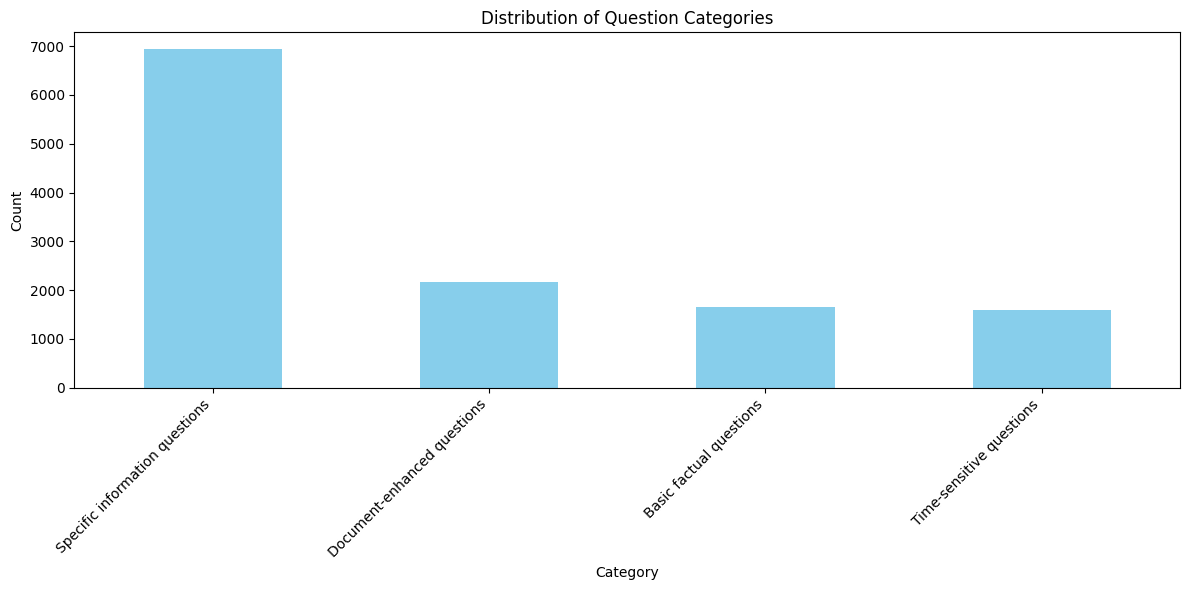

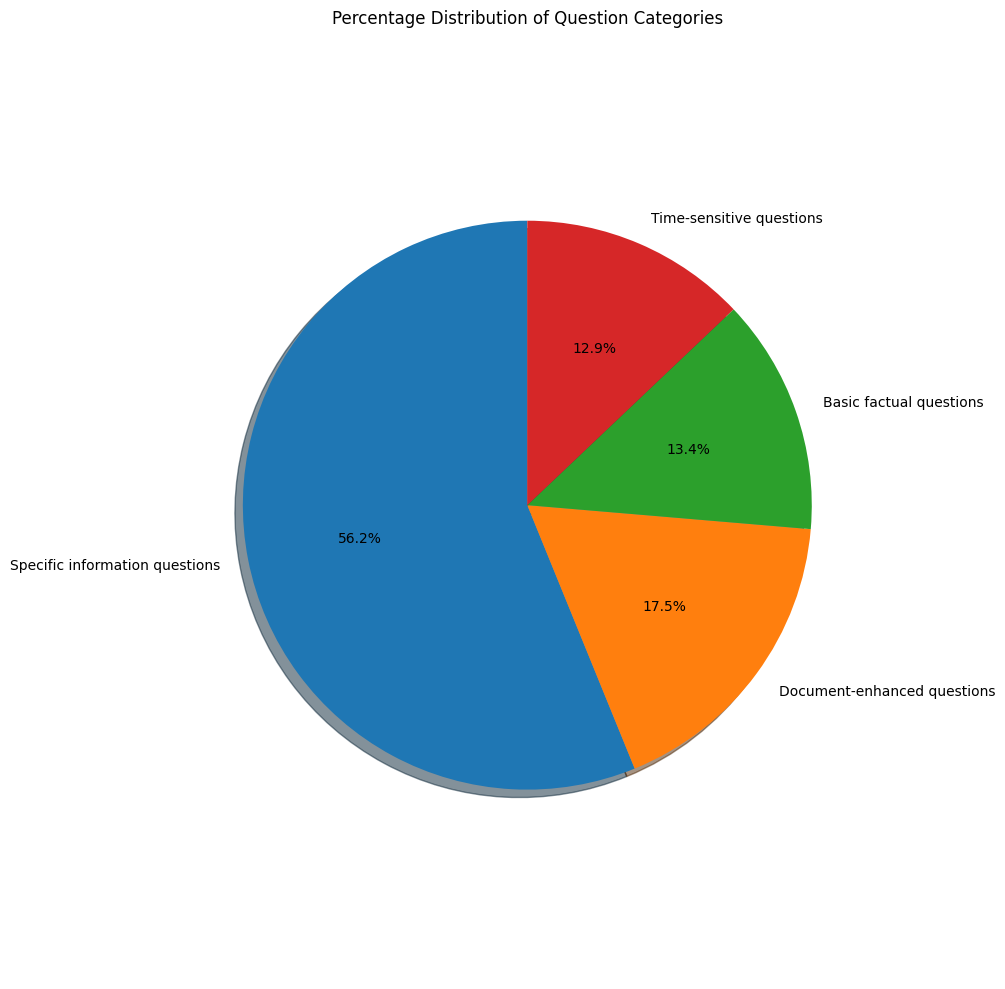

In [54]:
# Calculate the distribution of categories
category_counts = category_df['category'].value_counts()

# Display the distribution
print("Distribution of question categories:")
print(category_counts)

# Calculate percentages
category_percentages = category_df['category'].value_counts(normalize=True) * 100
print("\nPercentage distribution:")
for category, percentage in category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

# Create a bar plot of the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Question Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a pie chart for percentage distribution
plt.figure(figsize=(10, 10))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
        startangle=90, shadow=True)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Percentage Distribution of Question Categories')
plt.tight_layout()
plt.show()


In [55]:
# Randomly sample 100 entries from each category
sampled_data = []

# Get unique categories
unique_categories = category_df['category'].unique()

# Sample from each category
for category in unique_categories:
    # Filter the dataframe for the current category
    category_data = category_df[category_df['category'] == category]
    
    # If there are less than 100 entries, take all of them
    # Otherwise, randomly sample 100 entries
    if len(category_data) <= 100:
        sampled = category_data
        print(f"Category '{category}' has only {len(category_data)} entries, taking all of them.")
    else:
        sampled = category_data.sample(n=100, random_state=42)
        print(f"Sampled 100 entries from category '{category}'.")
    
    # Add the sampled data to our list
    sampled_data.append(sampled)

# Combine all sampled data into a single dataframe
balanced_sample_df = pd.concat(sampled_data, ignore_index=True)

# Display the count of entries in each category in the balanced sample
print("\nDistribution in balanced sample:")
print(balanced_sample_df['category'].value_counts())

# Save the balanced sample to a CSV file
balanced_sample_df.to_csv("gemma3_balanced_sample.csv", index=False)
print(f"\nSaved balanced sample with {len(balanced_sample_df)} entries to 'gemma3_balanced_sample.csv'")


Sampled 100 entries from category 'Time-sensitive questions'.
Sampled 100 entries from category 'Specific information questions'.
Sampled 100 entries from category 'Document-enhanced questions'.
Sampled 100 entries from category 'Basic factual questions'.

Distribution in balanced sample:
category
Time-sensitive questions          100
Specific information questions    100
Document-enhanced questions       100
Basic factual questions           100
Name: count, dtype: int64

Saved balanced sample with 400 entries to 'gemma3_balanced_sample.csv'


In [58]:
balanced_sample_df.head(10)

,source,text,gemma3:12b_question,gemma3:12b_answer,category
0,https://www.pittsburghpa.gov/City-Government/M...,...,What is the purpose of the Late Night Basketba...,"The Late Night Basketball Initiative, led by M...",Time-sensitive questions
1,https://www.pittsburghpa.gov/Safety/Alerts/Pub...,30/10/2018 13:09:28 Update on Injured Poli...,What were the injuries sustained by Pittsburgh...,According to the Public Safety Department's up...,Time-sensitive questions
2,https://www.visitpittsburgh.com/blog/live-your...,Live Your Pittsburgh Romanti...,What categories of travel experiences are high...,The Visit Pittsburgh website highlights catego...,Time-sensitive questions
3,Downtown_Pittsburgh_Events_20250310_004602.json,"Community,\n>>>>>>> b908513ca90e848d0de1d449a8...",What special offerings will be available at Sp...,Space Bar will offer Special Irish Coffee & Da...,Time-sensitive questions
4,https://www.visitpittsburgh.com/blog/trace-ech...,The beer continues to get...,What exclusive beverage offering does Trace Ec...,Trace Echo exclusively offers 'A Few Bad Apple...,Time-sensitive questions
5,https://carnegieart.org/exhibition/tatiana-bil...,"Sep 21, 2024 - Jun 15, 2025\n>>>>>>> 2c80a1b63...",What is the exhibition 'Tatiana Bilbao Estudio...,The exhibition 'Tatiana Bilbao Estudio: City o...,Time-sensitive questions
6,https://www.pittsburghpa.gov/Safety/Alerts/Pub...,"(PITTSBURGH, PA), June 22, 2023 --The Pittsb...",What was Sergeant Dawn Mercurio’s career path ...,Sergeant Dawn Mercurio began her policing care...,Time-sensitive questions
7,Pittsburgh_City_Paper_Events_Page_20_20250310_...,Freshworks: Anya Collins - Fugue\n>>>>>>> b908...,What is the central theme explored in Anya Col...,Anya Collins's 'Fugue' explores the relationsh...,Time-sensitive questions
8,https://www.pittsburghpa.gov/Safety/Alerts/Pub...,31/3/2018 15:25:46 Test Test 4/4/2018 ...,What illegal substances and other items did Pi...,"Detectives recovered crack cocaine, heroin, ma...",Time-sensitive questions
9,Pittsburgh_Events_August_20250310_004620.json,Aug\n>>>>>>> b908513ca90e848d0de1d449a84290738...,What is the scheduled time for the Cincinnati ...,The Cincinnati Reds at Pittsburgh Pirates game...,Time-sensitive questions


In [59]:
# Add a new column called 'selected' to the balanced_sample_df
balanced_sample_df['selected'] = False

# Display the first few rows to confirm the new column was added
print("Added 'selected' column to balanced_sample_df:")
balanced_sample_df[['source', 'gemma3:12b_question', 'category', 'selected']].head()


Added 'selected' column to balanced_sample_df:


,source,gemma3:12b_question,category,selected
0,https://www.pittsburghpa.gov/City-Government/M...,What is the purpose of the Late Night Basketba...,Time-sensitive questions,False
1,https://www.pittsburghpa.gov/Safety/Alerts/Pub...,What were the injuries sustained by Pittsburgh...,Time-sensitive questions,False
2,https://www.visitpittsburgh.com/blog/live-your...,What categories of travel experiences are high...,Time-sensitive questions,False
3,Downtown_Pittsburgh_Events_20250310_004602.json,What special offerings will be available at Sp...,Time-sensitive questions,False
4,https://www.visitpittsburgh.com/blog/trace-ech...,What exclusive beverage offering does Trace Ec...,Time-sensitive questions,False


In [10]:
import requests
import json

def categorize_url(url, model_name="llama3.2"):
    """
    Categorize a given URL into one of the predefined categories using an Ollama model.
    
    Args:
        url (str): The URL to categorize
        model_name (str): The name of the Ollama model to use (default: "llama3.2")
        
    Returns:
        str: Category number of the URL (1-4)
    """
    # Ollama API endpoint (default is localhost on port 11434)
    api_url = "http://localhost:11434/api/generate"
    
    # Create the prompt for URL categorization
    prompt = f"""
    Analyze the following URL and classify it into exactly ONE of these four categories.
    
    URL: {url}
    
    CATEGORIES:
    1. General Info and History of Pittsburgh/CMU - URLs about Pittsburgh or CMU history, general information, city webpages, encyclopedias, etc.
    2. Events in Pittsburgh and CMU - URLs for calendars, event listings, festivals, upcoming activities, etc.
    3. Music and Culture - URLs about symphony, opera, museums, cultural venues, food festivals, etc.
    4. Sports - URLs about Pittsburgh sports teams (Pirates, Steelers, Penguins), sporting venues, sports information, etc.
    
    INSTRUCTIONS:
    - Respond with ONLY the category number (1, 2, 3, or 4)
    - Do not include any explanations, reasoning, or additional text
    - Output must be only a single digit from 1-4
    
    CATEGORY:
    """
    
    # Prepare the request payload
    payload = {
        "model": model_name,
        "prompt": prompt,
        "stream": False,
        "temperature": 0.1  # Lower temperature for more deterministic outputs
    }
    
    try:
        # Make the API request to Ollama
        response = requests.post(api_url, json=payload)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        # Parse the response and extract just the category number
        result = response.json()
        response_text = result["response"].strip()
        
        # Additional processing to ensure we only get a category number
        for char in response_text:
            if char in ["1", "2", "3", "4"]:
                return char
        
        # If no valid category was found in the response
        print(f"Warning: Could not extract a valid category from response: {response_text}")
        return None
    
    except requests.exceptions.RequestException as e:
        print(f"Error communicating with Ollama: {e}")
        return None
    except (KeyError, json.JSONDecodeError) as e:
        print(f"Error processing Ollama response: {e}")
        return None

In [13]:
categorize_url("https://www.pittsburghpa.gov/", model_name="gemma3:12b")

'1'

In [7]:
def categorize_url_for_dataset(df, model_name="llama3.3:latest", max_attempts=5, save_path="all_combined.csv"):
    """
    Generate questions for each text in the dataframe using the specified model.
    
    Args:
        df: DataFrame containing a 'text' column
        model_name: Name of the model to use for question generation
        max_attempts: Maximum number of attempts for each text
        save_path: Path to save the updated dataframe
        
    Returns:
        Updated DataFrame with a new column containing generated questions
    """

    
    all_categories = []
    dictionary = {'1': 'General Info and History of Pittsburgh/CMU', '2': 'Events in Pittsburgh and CMU', '3': 'Music and Culture', '4': 'Sports'}
    # Add tqdm progress bar
    for i in tqdm(range(len(df)), desc=f"Generating questions with {model_name}"):
        # if i % 100 == 0:
        #     print("current row index: ", i)
        attempts = 0
        
        while attempts < max_attempts:
            try:
                response = categorize_url(df["source"][i], model_name=model_name)
                # print("The text is: ", df["text"][i])
                
                if response in dictionary:  # If we got a valid response
                    # print("-------- ---------")
                    # print(question)
                    # print(answer)
                    # print("-------- ---------")
                    break
                raise Exception("Empty response received")
                
            except Exception as e:
                attempts += 1
                print(f"Attempt {attempts} failed: {str(e)}")
                if attempts == max_attempts:
                    print(f"Failed to generate question after {max_attempts} attempts")
        if response in dictionary:
            all_categories.append(dictionary[response])
        else:
            all_categories.append("")

    # After collecting all questions, add them as a new column
    column_name = f"content_category"
    df[column_name] = all_categories


    # Save the final dataframe once at the end
    df.to_csv(save_path, index=False)
    
    return df

In [15]:
import pandas as pd
from tqdm import tqdm
df = pd.read_csv("gemma3_questions_filtered_tmp.csv", lineterminator='\n')
categorize_url_for_dataset(df, model_name="gemma3:12b", save_path="gemma3_questions_filtered_tmp_with_2cat.csv")

Generating questions with gemma3:12b: 100%|██████████| 12352/12352 [14:40<00:00, 14.03it/s]


,source,text,gemma3:12b_question,gemma3:12b_answer,category,content_category
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio...",Time-sensitive questions,Music and Culture
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...,Specific information questions,Music and Culture
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...,Time-sensitive questions,Music and Culture
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...,Time-sensitive questions,Music and Culture
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi...",Document-enhanced questions,Music and Culture
...,...,...,...,...,...,...
12347,2024_Operating_Budget.pdf,Anticipated 2028 Issuance ($49 million plus 1%...,What is the amount of debt service for the Cit...,The City of Pittsburgh Operating Budget for Fi...,Specific information questions,General Info and History of Pittsburgh/CMU
12348,2024_Operating_Budget.pdf,Pension Funding 318,What is the title of the text chunk provided?,The text chunk is titled 'Pension Funding 318'.,Document-enhanced questions,General Info and History of Pittsburgh/CMU
12349,2024_Operating_Budget.pdf,City of Pittsburgh Operating Budget Fiscal Ye...,What is the subject of document 319 within the...,Document 319 within the City of Pittsburgh Ope...,Specific information questions,General Info and History of Pittsburgh/CMU
12350,2024_Operating_Budget.pdf,City of Pittsburgh Operating Budget Fiscal Ye...,What is the subject of the City of Pittsburgh'...,The City of Pittsburgh Operating Budget for Fi...,Specific information questions,General Info and History of Pittsburgh/CMU


In [16]:
df_2cat = pd.read_csv("gemma3_questions_filtered_tmp_with_2cat.csv", lineterminator='\n')
df_2cat.head()


,source,text,gemma3:12b_question,gemma3:12b_answer,category,content_category
0,https://www.heinzhistorycenter.org/event/irish...,Skip Main NavigationSkip to site alert\nHeinz ...,What dates will the one-on-one consultation se...,"The individual, one-on-one consultation sessio...",Time-sensitive questions,Music and Culture
1,https://www.heinzhistorycenter.org/event/one-o...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the cost of a single 30-minute consult...,Each 30-minute consultation session is priced ...,Specific information questions,Music and Culture
2,https://www.heinzhistorycenter.org/event/histo...,Skip Main NavigationSkip to site alert\nHeinz ...,What is the date and time of the History Uncor...,History Uncorked: Mirror Ball will be held on ...,Time-sensitive questions,Music and Culture
3,https://www.heinzhistorycenter.org/event/speak...,Skip Main NavigationSkip to site alert\nHeinz ...,When will Jason A. Cherry's lecture on 'Willia...,Jason A. Cherry’s lecture will take place on S...,Time-sensitive questions,Music and Culture
4,https://www.heinzhistorycenter.org/event/gut-y...,Skip Main NavigationSkip to site alert\nHeinz ...,What does the Yiddish greeting 'Gut Yontif' me...,"According to the text, 'Gut Yontif' is a Yiddi...",Document-enhanced questions,Music and Culture
